#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

В этой ЛР мы рассматриваем задачу генерации текста. Верхнеуровнево это выглядит так: по текущему токену и некоторой информации о предыдущих токенах наша цель - сгенерировать следующий токен. Похожие вещи мы раньше делали, оценивая вероятностные распределения. Модель на биграммах - частный случай (история = один предыдущий токен).

Теперь мы усложняем модель и в качестве истории используем вектор скрытого состояния RNN, который получен после обработки части последовательности. Новый промежуточный вектор скрытого состояния можно использовать для прогноза следующего токена.

In [2]:
import torch as th

batch_size, seq_len, vocab_size = 8, 5, 10
data = th.randint(0, vocab_size, size=(batch_size, seq_len)) # входные последовательности
data

tensor([[3, 4, 2, 8, 9],
        [0, 1, 2, 8, 4],
        [4, 4, 7, 3, 7],
        [3, 0, 7, 0, 5],
        [1, 9, 6, 2, 6],
        [3, 3, 1, 6, 6],
        [9, 8, 6, 3, 1],
        [4, 6, 6, 6, 6]])

Для обучения нужны примеры и ответы. Мы можем получить их из исходных данных, имея в виду решаемую задачу. Для конкретного токена правильный "ответ" в нашей постановке задачи - это следующий за ним токен

In [3]:
X_t = data[:, :-1]
y_t = data[:, 1:]

In [4]:
import torch.nn as nn

embedding_dim = 10
emb = nn.Embedding(num_embeddings=10, embedding_dim=embedding_dim) # каждый токен заменяем на вектор
X_e = emb(X_t)
X_e.shape

torch.Size([8, 4, 10])

In [5]:
hidden_size = 7
rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

out, h = rnn(X_e) # пропускаем последовательности через RNN
out.shape

torch.Size([8, 4, 7])

out - это векторы скрытых состояний после обработки очередного элемента последовательностей. Для каждого примера батча есть 4 (seq_len - 1) таких векторов. Каждый из них мы можем использовать для прогноза

In [6]:
fc = nn.Linear(hidden_size, vocab_size)
y_preds = fc(out)
y_preds.shape

torch.Size([8, 4, 10])

На этом этапе у нас каждый из векторов имеет размерность 10 (по количеству уникальных токенов в словаре). Каждый из этих векторов трактуем как логиты. Цель - добиться того, чтобы логит, соответствующий правильному ответу (реально идущему далее слову) был побольше. В этом месте нам уже не нужна трехмерная структура.

In [7]:
y_preds_2d = y_preds.reshape(batch_size * (seq_len - 1), -1)
y_preds_2d.shape

torch.Size([32, 10])

In [8]:
y_t.flatten().shape

torch.Size([32])

Теперь можно посчитать значение функции потерь и поотпимизировать его в стандартном цикле обучения.

Во всей этой процедуре есть один токен, который будет встречаться очень часто - PAD. Вопрос: какое воздействие он должен оказывать на итоговое значение функции потерь? По факту, нас не интересуют прогнозы для этих токенов, т.к. они чисто служебные. Для учета этого факта можно рассмотреть параметр ignore_index при создании функции потерь.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Tokenizer на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

----------
(https://habr.com/ru/articles/567142): <br>
начало последовательности (\<sos> — start of sequence) \
и конец последовательности (\<eos> — end of sequence)


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NLP/9/pets_ru_en.csv')
df.columns

Index(['имя', 'язык'], dtype='object')

In [11]:
df.head(5)

,имя,язык
0,Acapella,en
1,Achilles,en
2,Adriana,en
3,Alpha,en
4,Alyssum,en


In [12]:
df.tail(5)

,имя,язык
2908,Ярика,rus
2909,Яриска,rus
2910,Ярка,rus
2911,Яркиса,rus
2912,Ярыся,rus


In [13]:
df['язык'].unique()

array(['en', 'rus'], dtype=object)

In [14]:
df['имя'] = df['имя'].str.lower()

In [15]:
df_unique = df.drop_duplicates(subset='имя', keep='last')

In [16]:
df.shape[0], df_unique.shape[0]

(2913, 2894)

In [17]:
all_letters = "".join(df_unique['имя'].tolist())

In [18]:
special = '<PAD>, <SOS>, <EOS>'.split(', ')
special

['<PAD>', '<SOS>', '<EOS>']

In [19]:
vocab = set(all_letters)

In [20]:



tokenizer = {token: idx for idx, token in enumerate(special +sorted(vocab))}
len(tokenizer)

63

In [21]:
tokenizer

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 ' ': 3,
 '-': 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'q': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'x': 28,
 'y': 29,
 'z': 30,
 'а': 31,
 'б': 32,
 'в': 33,
 'г': 34,
 'д': 35,
 'е': 36,
 'ж': 37,
 'з': 38,
 'и': 39,
 'й': 40,
 'к': 41,
 'л': 42,
 'м': 43,
 'н': 44,
 'о': 45,
 'п': 46,
 'р': 47,
 'с': 48,
 'т': 49,
 'у': 50,
 'ф': 51,
 'х': 52,
 'ц': 53,
 'ч': 54,
 'ш': 55,
 'щ': 56,
 'ы': 57,
 'ь': 58,
 'э': 59,
 'ю': 60,
 'я': 61,
 'ё': 62}

<p class="task" id="2"></p>

2\. Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

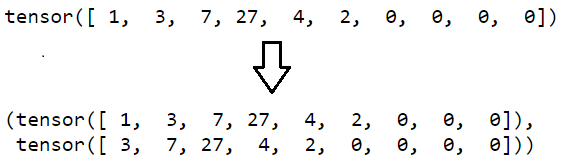

- [ ] Проверено на семинаре

In [22]:
[1, 2, 3][:-1]

[1, 2]

In [72]:
from torch.utils.data import Dataset
import torch


class PetsGenDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # uniq = df['класс'].unique()
        # self.label = {cls: idx for idx, cls in enumerate(uniq)}


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        name = row#['имя']
        # cls = row['класс']

        tokens = [self.tokenizer[i] for i in name]

        tokens = [1] + tokens + [2] + [0] * (self.max_len - len(tokens))

        return torch.tensor(tokens[:-1], dtype=torch.long), torch.tensor(tokens[1:], dtype=torch.long)
        # return torch.tensor(tokens, dtype=torch.long), torch.tensor(self.label[cls], dtype=torch.long)


In [24]:
max_len = df_unique['имя'].str.len().max()
max_len

22

In [25]:
names = PetsGenDataset(df_unique['имя'], tokenizer, max_len)

In [26]:
from torch.utils.data import DataLoader


dataloader = DataLoader(names, batch_size=128, shuffle=True)

In [27]:
for x, y in dataloader:
    print(x)
    print(y)
    break

tensor([[ 1,  8,  5,  ...,  0,  0,  0],
        [ 1, 41, 48,  ...,  0,  0,  0],
        [ 1, 20,  9,  ...,  0,  0,  0],
        ...,
        [ 1, 42, 60,  ...,  0,  0,  0],
        [ 1, 51, 47,  ...,  0,  0,  0],
        [ 1, 46, 31,  ...,  0,  0,  0]])
tensor([[ 8,  5, 13,  ...,  0,  0,  2],
        [41, 48, 60,  ...,  0,  0,  2],
        [20,  9, 18,  ...,  0,  0,  2],
        ...,
        [42, 60, 48,  ...,  0,  0,  2],
        [51, 47, 31,  ...,  0,  0,  2],
        [46, 31, 49,  ...,  0,  0,  2]])


In [28]:
x.shape, y.shape

(torch.Size([128, 23]), torch.Size([128, 23]))

<p class="task" id="3"></p>

3\. Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [29]:
q = torch.softmax(torch.tensor([1, 2, 3, 4, 5], dtype=torch.long).float(), dim=-1)
q

tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])

In [30]:
torch.multinomial(q, num_samples=1)

tensor([3])

получаем веса, софтмаксом получаем вероятности и выбираем согласно вероятностям, выводя индекс

In [31]:
def generate_name(model, tokenizer, max_len):
    t2v = {v: k for k, v in tokenizer.items()}

    res = [1]
    h_t = None

    for i in range(max_len):
        input_token = res[-1]
        if input_token == 2:
            break
        logits, h_t = model(torch.tensor([[input_token]], dtype=torch.long), h_t)
        probs = torch.softmax(logits.squeeze(0), dim=-1)
        res.append(torch.multinomial(probs, num_samples=1).item())

    word = [t2v[i] for i in res if i not in [0, 1, 2]]

    return ''.join(word).capitalize()

<p class="task" id="4"></p>

4\. Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки.

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [32]:
import torch.nn as nn
import torch.optim as optim

In [33]:
class PetModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, vocab_size)
        )


    def forward(self, x, h_t=None):
        emb_X = self.embedding(x)
        o, h_t = self.rnn(emb_X, h_t)
        b, seq, h = o.size()

        o = o.reshape(b*seq, h)

        logits = self.fc(o)
        return logits, h_t

In [34]:
vocab_size = len(tokenizer)
embedding_size = 64

hidden_size = 10
epochs = 30

print_out = 5

попробую запустить без игнорирования pad, чтобы увидеть разницу и ответить на вопрос перед заданиями

без ignore_index

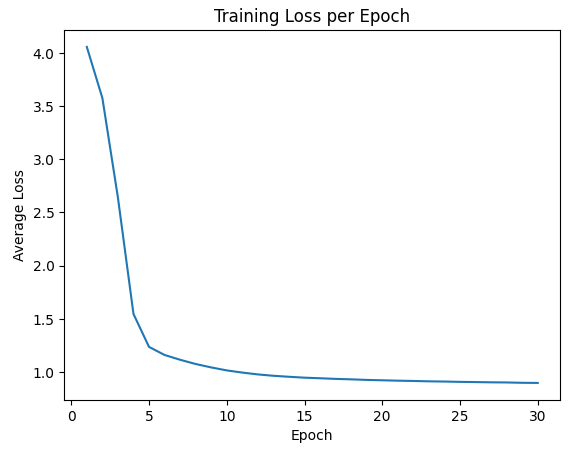

c ignore_index

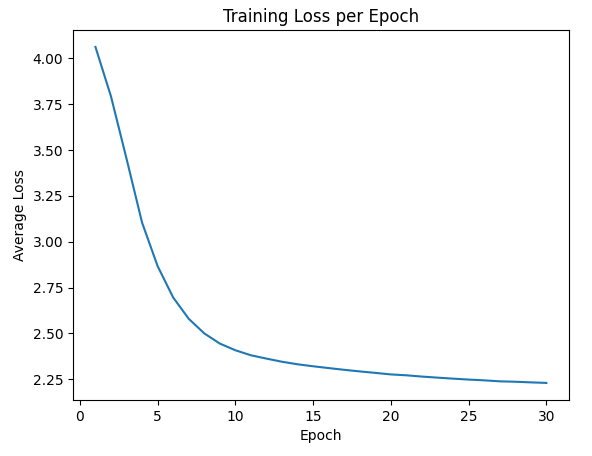

In [35]:
model = PetModel(vocab_size, embedding_size, hidden_size)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_result = []

In [36]:
from tqdm import tqdm

In [37]:
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for inputs, targets in loop:
        optimizer.zero_grad()

        logits, _ = model(inputs)
        loss = criterion(logits, targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_result.append(avg_loss)

    print(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

    if epoch % print_out == 0:
        model.eval()
        print(generate_name(model, tokenizer, max_len))


Epoch 1/30 - Average Loss: 4.0220


Epoch 2/30 - Average Loss: 3.7830


Epoch 3/30 - Average Loss: 3.4878


Epoch 4/30 - Average Loss: 3.1307


Epoch 5/30 - Average Loss: 2.8136
Эuофнираяабаратнслшота


Epoch 6/30 - Average Loss: 2.6578


Epoch 7/30 - Average Loss: 2.5750


Epoch 8/30 - Average Loss: 2.5095


Epoch 9/30 - Average Loss: 2.4563


Epoch 10/30 - Average Loss: 2.4136
Syrybesenerarzhagercce


Epoch 11/30 - Average Loss: 2.3820


Epoch 12/30 - Average Loss: 2.3621


Epoch 13/30 - Average Loss: 2.3443


Epoch 14/30 - Average Loss: 2.3320


Epoch 15/30 - Average Loss: 2.3213
Нсининтюмйлекининилала


Epoch 16/30 - Average Loss: 2.3120


Epoch 17/30 - Average Loss: 2.3039


Epoch 18/30 - Average Loss: 2.2974


Epoch 19/30 - Average Loss: 2.2906


Epoch 20/30 - Average Loss: 2.2854
Ассанtarinuezvunfpeнка


Epoch 21/30 - Average Loss: 2.2805


Epoch 22/30 - Average Loss: 2.2733


Epoch 23/30 - Average Loss: 2.2691


Epoch 24/30 - Average Loss: 2.2624


Epoch 25/30 - Average Loss: 2.2596
Нафитаниликаг факеттай


Epoch 26/30 - Average Loss: 2.2553


Epoch 27/30 - Average Loss: 2.2520


Epoch 28/30 - Average Loss: 2.2454


Epoch 29/30 - Average Loss: 2.2438


Epoch 30/30 - Average Loss: 2.2387
Ивниженорасентарьазфил


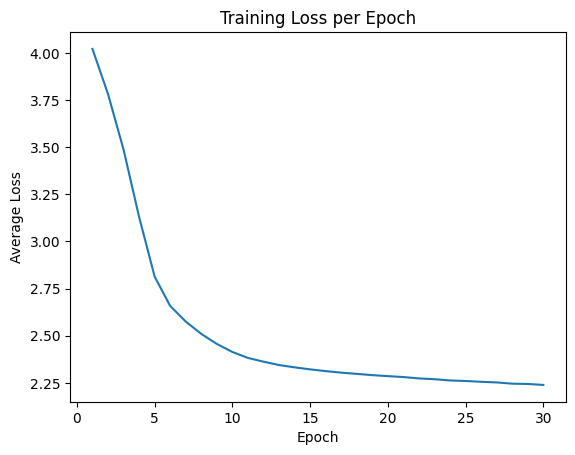

In [38]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), loss_result)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.show()

<p class="task" id="5"></p>

5\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре.

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [39]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NLP/9/pets_ru_en.csv')
df.columns

Index(['имя', 'язык'], dtype='object')

In [40]:
df['язык'].unique()

array(['en', 'rus'], dtype=object)

In [41]:
df['имя'] = df['имя'].str.lower()

In [42]:
all_letters = "".join(df['имя'].tolist())

In [43]:
special = '<PAD>, <SOS>, <EOS>, <RU>, <EN>'.split(', ')
special

['<PAD>', '<SOS>', '<EOS>', '<RU>', '<EN>']

In [44]:
vocab = set(all_letters)

In [45]:
tokenizer = {token: idx for idx, token in enumerate(special +sorted(vocab))}
len(tokenizer)

65

In [46]:
tokenizer['<RU>'], tokenizer['<EN>']

(3, 4)

In [73]:
from torch.utils.data import Dataset
import torch


class PetsGenDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        name = row['имя']
        cls = row['язык']
        if cls == 'en':
            cls = 4
        else:
            cls = 3

        tokens = [self.tokenizer[i] for i in name]

        tokens = [cls] + [1] + tokens + [2] + [0] * (self.max_len - len(tokens))

        return torch.tensor(tokens[:-1], dtype=torch.long), torch.tensor(tokens[1:], dtype=torch.long)


In [74]:
max_len = df['имя'].str.len().max()
max_len

22

In [75]:
names = PetsGenDataset(df, tokenizer, max_len)

In [76]:
dataloader = DataLoader(names, batch_size=128, shuffle=True)

In [77]:
for x, y in dataloader:
    print(x)
    print(y)
    break

tensor([[ 4,  1, 15,  ...,  0,  0,  0],
        [ 4,  1,  8,  ...,  0,  0,  0],
        [ 3,  1, 44,  ...,  0,  0,  0],
        ...,
        [ 4,  1, 10,  ...,  0,  0,  0],
        [ 4,  1, 21,  ...,  0,  0,  0],
        [ 3,  1, 53,  ...,  0,  0,  0]])
tensor([[ 1, 15,  7,  ...,  0,  0,  0],
        [ 1,  8,  7,  ...,  0,  0,  0],
        [ 1, 44, 41,  ...,  0,  0,  0],
        ...,
        [ 1, 10, 27,  ...,  0,  0,  0],
        [ 1, 21, 20,  ...,  0,  0,  0],
        [ 1, 53, 33,  ...,  0,  0,  0]])


<p class="task" id="6"></p>

6\. Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки.

- [ ] Проверено на семинаре


In [78]:
def generate_name(model, tokenizer, max_len, language):
    t2v = {v: k for k, v in tokenizer.items()}

    res = [tokenizer[language]]
    h_t = None

    for i in range(max_len):
        input_token = res[-1]
        if input_token == 2:
            break
        logits, h_t = model(torch.tensor([[input_token]], dtype=torch.long), h_t)
        probs = torch.softmax(logits.squeeze(0), dim=-1)
        res.append(torch.multinomial(probs, num_samples=1).item())

    word = [t2v[i] for i in res if i not in [0, 1, 2, 3, 4]]

    return language, ''.join(word).capitalize()

In [79]:
class PetModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, vocab_size)
        )


    def forward(self, x, h_t=None):
        emb_X = self.embedding(x)
        o, h_t = self.rnn(emb_X, h_t)
        b, seq, h = o.size()

        o = o.reshape(b*seq, h)

        logits = self.fc(o)
        return logits, h_t

In [80]:
vocab_size = len(tokenizer)
embedding_size = 64

hidden_size = 10
epochs = 50

print_out = 5

In [81]:
model = PetModel(vocab_size, embedding_size, hidden_size)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_result = []

In [82]:
language = '<RU> <EN>'.split()
language

['<RU>', '<EN>']

In [83]:
import random
random.choice(language)

'<EN>'

In [84]:
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for inputs, targets in loop:
        optimizer.zero_grad()

        logits, _ = model(inputs)
        loss = criterion(logits, targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_result.append(avg_loss)

    print(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

    if epoch % print_out == 0:
        model.eval()

        print(generate_name(model, tokenizer, max_len, random.choice(language)))


Epoch 1/50 - Average Loss: 4.0846


Epoch 2/50 - Average Loss: 3.8480


Epoch 3/50 - Average Loss: 3.4704


Epoch 4/50 - Average Loss: 3.0387


Epoch 5/50 - Average Loss: 2.7372
('<RU>', 'Sиалоиа')


Epoch 6/50 - Average Loss: 2.5480


Epoch 7/50 - Average Loss: 2.4383


Epoch 8/50 - Average Loss: 2.3649


Epoch 9/50 - Average Loss: 2.3101


Epoch 10/50 - Average Loss: 2.2648
('<EN>', 'Mvebimwa')


Epoch 11/50 - Average Loss: 2.2277


Epoch 12/50 - Average Loss: 2.1961


Epoch 13/50 - Average Loss: 2.1681


Epoch 14/50 - Average Loss: 2.1466


Epoch 15/50 - Average Loss: 2.1290
('<RU>', 'Чияка')


Epoch 16/50 - Average Loss: 2.1150


Epoch 17/50 - Average Loss: 2.1032


Epoch 18/50 - Average Loss: 2.0940


Epoch 19/50 - Average Loss: 2.0852


Epoch 20/50 - Average Loss: 2.0790
('<EN>', 'Ciasni')


Epoch 21/50 - Average Loss: 2.0724


Epoch 22/50 - Average Loss: 2.0664


Epoch 23/50 - Average Loss: 2.0611


Epoch 24/50 - Average Loss: 2.0554


Epoch 25/50 - Average Loss: 2.0516
('<EN>', 'Beno')


Epoch 26/50 - Average Loss: 2.0476


Epoch 27/50 - Average Loss: 2.0421


Epoch 28/50 - Average Loss: 2.0378


Epoch 29/50 - Average Loss: 2.0348


Epoch 30/50 - Average Loss: 2.0293
('<RU>', 'Элла')


Epoch 31/50 - Average Loss: 2.0267


Epoch 32/50 - Average Loss: 2.0237


Epoch 33/50 - Average Loss: 2.0199


Epoch 34/50 - Average Loss: 2.0165


Epoch 35/50 - Average Loss: 2.0130
('<RU>', 'Релки')


Epoch 36/50 - Average Loss: 2.0103


Epoch 37/50 - Average Loss: 2.0080


Epoch 38/50 - Average Loss: 2.0055


Epoch 39/50 - Average Loss: 2.0031


Epoch 40/50 - Average Loss: 1.9983
('<EN>', 'Hoxph')


Epoch 41/50 - Average Loss: 1.9973


Epoch 42/50 - Average Loss: 1.9946


Epoch 43/50 - Average Loss: 1.9913


Epoch 44/50 - Average Loss: 1.9881


Epoch 45/50 - Average Loss: 1.9869
('<EN>', 'Pifront')


Epoch 46/50 - Average Loss: 1.9840


Epoch 47/50 - Average Loss: 1.9820


Epoch 48/50 - Average Loss: 1.9801


Epoch 49/50 - Average Loss: 1.9776


Epoch 50/50 - Average Loss: 1.9757
('<EN>', 'Grials')


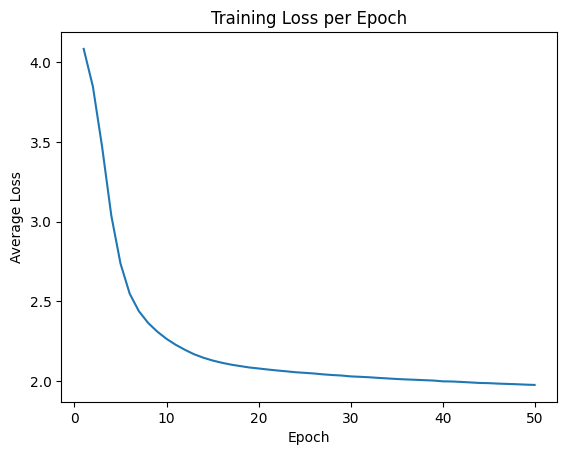

In [85]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), loss_result)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.show()

мне кажется что pad не стоит игнорировать, не уверен, но кажется что без игнора будет лучше

In [86]:
model = PetModel(vocab_size, embedding_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
loss_result_ = []

In [87]:
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for inputs, targets in loop:
        optimizer.zero_grad()

        logits, _ = model(inputs)
        loss = criterion(logits, targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_result_.append(avg_loss)

    print(f"Epoch {epoch}/{epochs} - Average Loss: {avg_loss:.4f}")

    if epoch % print_out == 0:
        model.eval()

        print(generate_name(model, tokenizer, max_len, random.choice(language)))


Epoch 1/50 - Average Loss: 4.0975


Epoch 2/50 - Average Loss: 3.6015


Epoch 3/50 - Average Loss: 2.6829


Epoch 4/50 - Average Loss: 1.5282


Epoch 5/50 - Average Loss: 1.1429
('<EN>', 'Mиsо')


Epoch 6/50 - Average Loss: 1.0242


Epoch 7/50 - Average Loss: 0.9427


Epoch 8/50 - Average Loss: 0.8867


Epoch 9/50 - Average Loss: 0.8508


Epoch 10/50 - Average Loss: 0.8252
('<RU>', 'Эукзла')


Epoch 11/50 - Average Loss: 0.8045


Epoch 12/50 - Average Loss: 0.7878


Epoch 13/50 - Average Loss: 0.7739


Epoch 14/50 - Average Loss: 0.7616


Epoch 15/50 - Average Loss: 0.7514
('<RU>', 'Oo')


Epoch 16/50 - Average Loss: 0.7431


Epoch 17/50 - Average Loss: 0.7357


Epoch 18/50 - Average Loss: 0.7301


Epoch 19/50 - Average Loss: 0.7245


Epoch 20/50 - Average Loss: 0.7190
('<EN>', 'Pasbl')


Epoch 21/50 - Average Loss: 0.7148


Epoch 22/50 - Average Loss: 0.7110


Epoch 23/50 - Average Loss: 0.7082


Epoch 24/50 - Average Loss: 0.7043


Epoch 25/50 - Average Loss: 0.7015
('<RU>', 'Эйси')


Epoch 26/50 - Average Loss: 0.6990


Epoch 27/50 - Average Loss: 0.6967


Epoch 28/50 - Average Loss: 0.6946


Epoch 29/50 - Average Loss: 0.6931


Epoch 30/50 - Average Loss: 0.6911
('<RU>', 'Юнеса')


Epoch 31/50 - Average Loss: 0.6893


Epoch 32/50 - Average Loss: 0.6875


Epoch 33/50 - Average Loss: 0.6856


Epoch 34/50 - Average Loss: 0.6844


Epoch 35/50 - Average Loss: 0.6825
('<EN>', 'Cfewer')


Epoch 36/50 - Average Loss: 0.6811


Epoch 37/50 - Average Loss: 0.6797


Epoch 38/50 - Average Loss: 0.6790


Epoch 39/50 - Average Loss: 0.6776


Epoch 40/50 - Average Loss: 0.6770
('<EN>', 'Setarcofoc')


Epoch 41/50 - Average Loss: 0.6754


Epoch 42/50 - Average Loss: 0.6740


Epoch 43/50 - Average Loss: 0.6730


Epoch 44/50 - Average Loss: 0.6722


Epoch 45/50 - Average Loss: 0.6715
('<RU>', 'Сина')


Epoch 46/50 - Average Loss: 0.6706


Epoch 47/50 - Average Loss: 0.6693


Epoch 48/50 - Average Loss: 0.6683


Epoch 49/50 - Average Loss: 0.6679


Epoch 50/50 - Average Loss: 0.6667
('<EN>', 'Bopotl')


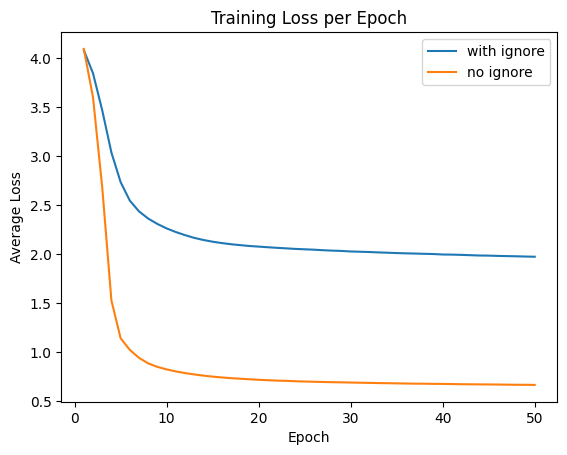

In [88]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), loss_result, label='with ignore')
plt.plot(range(1, epochs+1), loss_result_, label='no ignore')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

мне кажется что не стоит игнорировать pad, без него даже вывод модели выглядел более адекватно

In [89]:
for i in range(20):
    if i % 2 == 0:
        language = '<RU>'
    else:
        language = '<EN>'

    print(generate_name(model, tokenizer, max_len, language))

('<RU>', 'Дрени')
('<EN>', 'Comly')
('<RU>', 'Халида')
('<EN>', 'Uindb')
('<RU>', 'Бофи')
('<EN>', 'Zimou')
('<RU>', 'Ффи жесюь')
('<EN>', 'Haunned')
('<RU>', 'Олейша')
('<EN>', 'Amepier')
('<RU>', 'Шус зи')
('<EN>', 'Asnee')
('<RU>', 'Храши')
('<EN>', 'Lanidio')
('<RU>', 'Жасуня')
('<EN>', 'Cittssox')
('<RU>', 'Илуя')
('<EN>', 'Fancele')
('<RU>', 'Хяма')
('<EN>', 'Palfy')
